In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from scipy.stats import pearsonr

In [13]:
# Step 1: Download the data
sp500 = yf.download('^GSPC', start='2020-01-01', end='2024-12-31')

# Use only 'Close' price and drop NaNs
data = sp500[['Close']].dropna()

print(data.head())

[*********************100%***********************]  1 of 1 completed

Price             Close
Ticker            ^GSPC
Date                   
2020-01-02  3257.850098
2020-01-03  3234.850098
2020-01-06  3246.280029
2020-01-07  3237.179932
2020-01-08  3253.050049


In [3]:
# Step 2: Train-test split (last 30 days test)
train_data = data[:-30]
test_data = data[-30:]

# Step 3: Scale data to [0,1] range
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_data)
scaled_test = scaler.transform(test_data)



In [4]:
# Step 4: Prepare sequences for LSTM
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X_train, y_train = create_sequences(scaled_train, seq_length)

# For testing, create sequences with train + test to avoid index errors
full_data = np.concatenate((scaled_train, scaled_test), axis=0)
X_test, y_test = create_sequences(full_data[-(30+seq_length):], seq_length)



In [5]:
# Step 5: Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Step 6: Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=1)



D:\SP500\sp_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1161
Epoch 2/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2690e-04
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8818e-04
Epoch 5/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3218e-04
Epoch 6/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0550e-04
Epoch 7/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2008e-04
Epoch 8/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7985e-04
Epoch 9/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8294e-04
Epoch 10/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9346e-04
Epoch 11/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3929e-04
Epoch 12/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5777e-04
Epoch 13/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1268e-04
Epoch 14/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9937e-04
Epoch 15/30
77/77 ━━━━━━━━━━━━━━━━━━━

In [6]:
# Step 7: Predict on test data
y_pred_scaled = model.predict(X_test)

# Inverse scale predictions and true values
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


In [12]:
# Step 8: Calculate metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

r2 = r2_score(y_true, y_pred)
correlation, _ = pearsonr(y_true.flatten(), y_pred.flatten())

# Directional accuracy
actual_diff = y_true[1:] - y_true[:-1]
pred_diff = y_pred[1:] - y_pred[:-1]
directional_accuracy = np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

print(f"🔮 LSTM RMSE: {rmse:.2f}")
print(f"📏 LSTM MAE: {mae:.2f}")
print(f"📉 LSTM MAPE: {mape:.2f}%")
print(f"📈 LSTM Directional Accuracy: {directional_accuracy:.2f}%")
print(f"📊 R² Score: {r2:.4f}")
print(f"🔗 Pearson Correlation: {correlation:.4f}")

🔮 LSTM RMSE: 89.80
📏 LSTM MAE: 69.05
📉 LSTM MAPE: 1.16%
📈 LSTM Directional Accuracy: 51.72%
📊 R² Score: -0.6222
🔗 Pearson Correlation: 0.5954


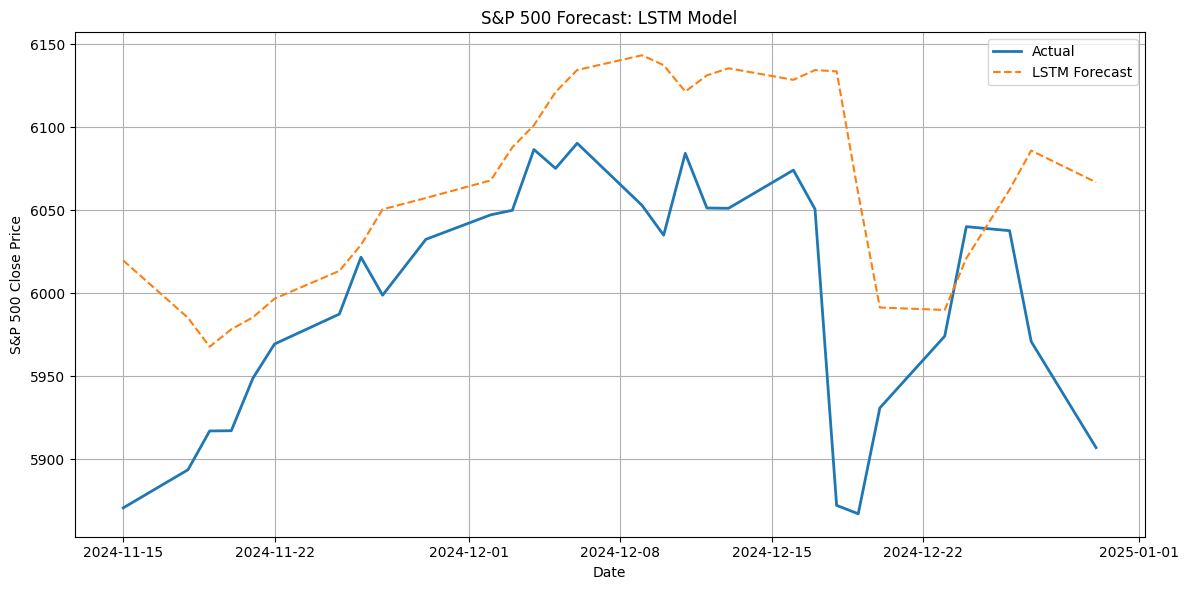

In [8]:
# Step 9: Plot actual vs predicted for test set
dates_test = data.index[-30:]

plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_true.flatten(), label='Actual', linewidth=2)
plt.plot(dates_test, y_pred.flatten(), label='LSTM Forecast', linestyle='--')
plt.title('S&P 500 Forecast: LSTM Model')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

📊 R² Score: -0.6222
